# 1-Define problem

- Origin: test if completion ratio is negatively correlated with Starts
- Revise: test if SF Starts positively correlated with 1 month prior SF permit

# 2-Prepare Data

## 2.1 Import library and configure dataset

In [132]:
#import library
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [133]:
# Read raw data
Category=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Category.csv',index_col=0,na_values='nan')
Data_Type=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Data_Type.csv',index_col=0,na_values='nan')
Error_Type=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Error_Type.csv',index_col=0,na_values='nan')
Geo_Level=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Geo_Level.csv',index_col=0,na_values='nan')
Time_Periods=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Time_Periods.csv',index_col=0,na_values='nan')
Z_Data=pd.read_csv ('C:\\Users\\hez\\Documents\\Python\\CB_RESCONST\\Z_Data.csv',na_values='nan')

In [134]:
#Merge all tables
Merge = pd.merge(Z_Data, Category, how="left", on="cat_idx")
Merge = pd.merge(Merge, Data_Type, how="left", on="dt_idx")
Merge = pd.merge(Merge, Error_Type, how="left", on="et_idx")
Merge = pd.merge(Merge, Geo_Level, how="left", on="geo_idx")
Merge = pd.merge(Merge, Time_Periods, how="left", on="per_idx")

In [135]:
df=Merge[['cat_code', 'cat_desc',
          #'cat_indent',
          'dt_code','dt_desc','dt_unit',
          'et_code','et_desc','et_unit',
          'geo_code','geo_desc',
          'per_name',
          'val','is_adj'
         ]]
df.head()

,cat_code,cat_desc,dt_code,dt_desc,dt_unit,et_code,et_desc,et_unit,geo_code,geo_desc,per_name,val,is_adj
0,PERMITS,Housing Units Authorized in Permit-Issuing Places,TOTAL,Total Units,K,NaN,NaN,NaN,US,United States,1/1/1959,75.7,0
1,PERMITS,Housing Units Authorized in Permit-Issuing Places,TOTAL,Total Units,K,NaN,NaN,NaN,NE,Northeast,1/1/1959,11.4,0
2,PERMITS,Housing Units Authorized in Permit-Issuing Places,TOTAL,Total Units,K,NaN,NaN,NaN,MW,Midwest,1/1/1959,11.8,0
3,PERMITS,Housing Units Authorized in Permit-Issuing Places,TOTAL,Total Units,K,NaN,NaN,NaN,SO,South,1/1/1959,26.8,0
4,PERMITS,Housing Units Authorized in Permit-Issuing Places,TOTAL,Total Units,K,NaN,NaN,NaN,WE,West,1/1/1959,25.6,0


In [136]:
#Change Data Type
#df = df.astype({"season_1":'category', "temp":'int64'}) 
# df = df.astype({'cat_code':'str', 'cat_desc':'str',
#           #'cat_indent',
#           'dt_code':'str','dt_desc':'str','dt_unit':'str',
#           'et_code':'str','et_desc':'str','et_unit':'str',
#           'geo_code':'str','geo_desc':'str',
#           'per_name':'str',
#           'val':'float'}) 
df['per_name'] = pd.to_datetime(df['per_name'])

In [137]:
#Rename columns
df.columns=['Category Code','Category Description',
            'Data Type Code','Data Type Description','Data Type Unit',
            'Error Type Code','Error Type Description','Error Type Unit',
            'Geo Level Code','Geo Level Description',
            'Period',
            'Value','Is_Adjusted?'
           ]

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79273 entries, 0 to 79272
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Category Code           79273 non-null  object        
 1   Category Description    79273 non-null  object        
 2   Data Type Code          62377 non-null  object        
 3   Data Type Description   62377 non-null  object        
 4   Data Type Unit          62377 non-null  object        
 5   Error Type Code         16896 non-null  object        
 6   Error Type Description  16896 non-null  object        
 7   Error Type Unit         16896 non-null  object        
 8   Geo Level Code          79273 non-null  object        
 9   Geo Level Description   79273 non-null  object        
 10  Period                  79273 non-null  datetime64[ns]
 11  Value                   79273 non-null  float64       
 12  Is_Adjusted?            79273 non-null  int64 

In [139]:
df['Data Type Code'].unique()

array(['TOTAL', 'SINGLE', 'MULTI', nan], dtype=object)

In [140]:
#Select US Adj Total Unit
df_Adj_Total_Unit_National=df[(df['Data Type Code']=='TOTAL')&(df['Error Type Code'].isnull())&(df['Geo Level Code']=='US')&(df['Is_Adjusted?']==1)]
#Select US adj SF Unit
df_Adj_SF_Unit_National=df[(df['Data Type Code']=='SINGLE')&(df['Error Type Code'].isnull())&(df['Geo Level Code']=='US')&(df['Is_Adjusted?']==1)]
#Select US adj MF Unit
df_Adj_MF_Unit_National=df[(df['Data Type Code']=='MULTI')&(df['Error Type Code'].isnull())&(df['Geo Level Code']=='US')&(df['Is_Adjusted?']==1)]

In [141]:
#Create PV table: Index-Period; Column-Category Description
pvt_Adj_Total_Unit_National = pd.pivot_table(df_Adj_Total_Unit_National, values='Value', index=['Period'],
                    columns=['Category Description'], aggfunc=np.sum)
pvt_Adj_SF_Unit_National= pd.pivot_table(df_Adj_SF_Unit_National, values='Value', index=['Period'],
                    columns=['Category Description'], aggfunc=np.sum)
pvt_Adj_MF_Unit_National= pd.pivot_table(df_Adj_MF_Unit_National, values='Value', index=['Period'],
                    columns=['Category Description'], aggfunc=np.sum)

In [142]:
#Drop NA-Annual Rate for Housing Units Completed
pvt_Adj_Total_Unit_National.dropna(axis=0,subset=['Annual Rate for Housing Units Completed'],inplace=True)
pvt_Adj_SF_Unit_National.dropna(axis=0,subset=['Annual Rate for Housing Units Completed'],inplace=True)

## 2.2 Exploratory Data Analysis

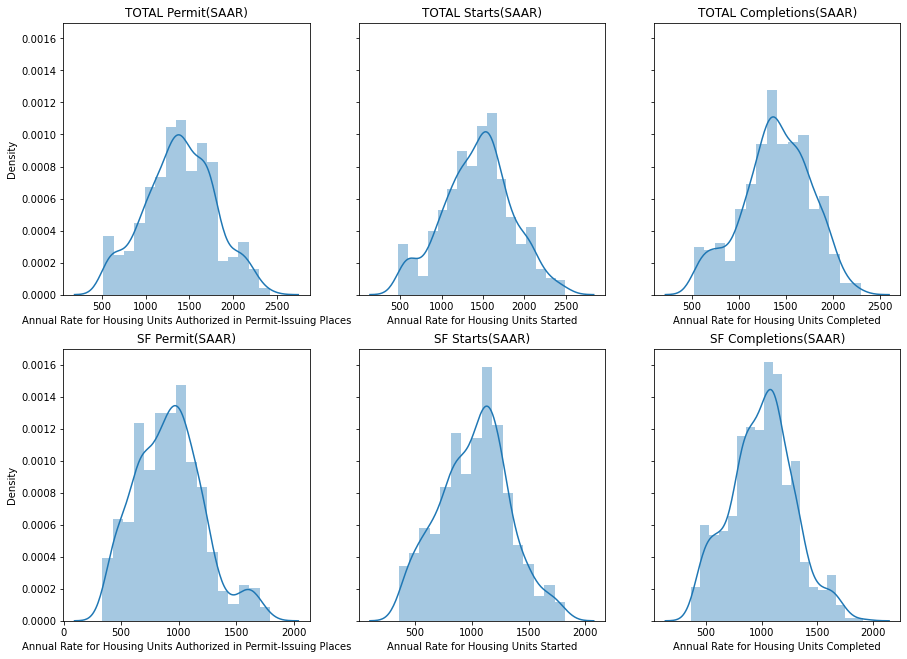

In [144]:
#Distribution
fig, axes = plt.subplots(2, 3, figsize=(15,11),sharey=True)
sns.distplot(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'],ax=axes[0,0]).set(title='TOTAL Permit(SAAR)')
sns.distplot(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'],ax=axes[0,1]).set(title='TOTAL Starts(SAAR)')
sns.distplot(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed'],ax=axes[0,2]).set(title='TOTAL Completions(SAAR)')
sns.distplot(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'],ax=axes[1,0]).set(title='SF Permit(SAAR)')
sns.distplot(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'],ax=axes[1,1]).set(title='SF Starts(SAAR)')
sns.distplot(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Completed'],ax=axes[1,2]).set(title='SF Completions(SAAR)')
plt.show()

In [145]:
# Shapiro-Wilk Normal Distribution Test
print(stats.shapiro(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places']))
print(stats.shapiro(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']))
print(stats.shapiro(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed']))
print(stats.shapiro(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places']))
print(stats.shapiro(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']))
print(stats.shapiro(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Completed']))
## Only Total Completion and SF Permit cannot reject ho: normal distribution but given the relative small sample size, we will give a pass here to use Pearson Coffelation Coefficient test

ShapiroResult(statistic=0.99163419008255, pvalue=0.0011195994447916746)
ShapiroResult(statistic=0.9921661019325256, pvalue=0.001884544501081109)
ShapiroResult(statistic=0.9870396852493286, pvalue=1.8916714907390997e-05)
ShapiroResult(statistic=0.9795342683792114, pvalue=8.447062072036715e-08)
ShapiroResult(statistic=0.9906414747238159, pvalue=0.00043574764276854694)
ShapiroResult(statistic=0.9907054305076599, pvalue=0.0004625643778126687)


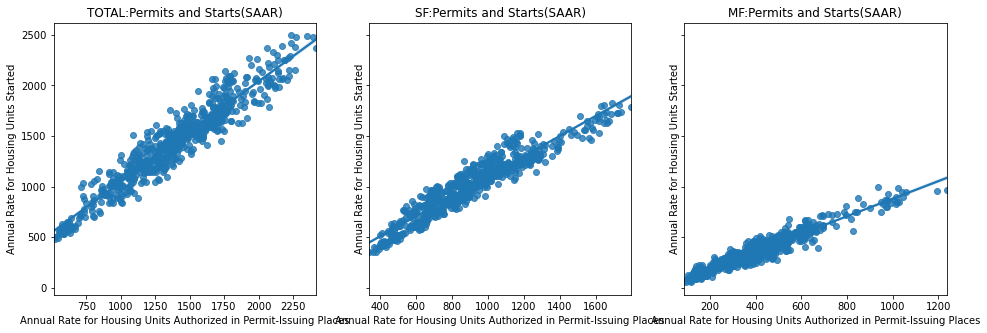

In [146]:
# Plot Permit and Starts
fig, axes = plt.subplots(1, 3, figsize=(16,5),sharey=True)
sns.regplot(ax=axes[0],x='Annual Rate for Housing Units Authorized in Permit-Issuing Places',y='Annual Rate for Housing Units Started',data=pvt_Adj_Total_Unit_National).set(title='TOTAL:Permits and Starts(SAAR)')
sns.regplot(ax=axes[1],x='Annual Rate for Housing Units Authorized in Permit-Issuing Places',y='Annual Rate for Housing Units Started',data=pvt_Adj_SF_Unit_National).set(title='SF:Permits and Starts(SAAR)')
sns.regplot(ax=axes[2],x='Annual Rate for Housing Units Authorized in Permit-Issuing Places',y='Annual Rate for Housing Units Started',data=pvt_Adj_MF_Unit_National).set(title='MF:Permits and Starts(SAAR)')
plt.show()
##------Linear Relationship

In [150]:
pvt_Adj_MF_Unit_National.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 736 entries, 1960-01-01 to 2021-04-01
Data columns (total 5 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Annual Rate for Housing Units Authorized in Permit-Issuing Places  736 non-null    float64
 1   Annual Rate for Housing Units Completed                            640 non-null    float64
 2   Annual Rate for Housing Units Started                              693 non-null    float64
 3   Housing Units Authorized But Not Started                           268 non-null    float64
 4   Housing Units Under Construction                                   616 non-null    float64
dtypes: float64(5)
memory usage: 34.5 KB


In [151]:
# Drop NA row of MF Starts and Permit
pvt_Adj_MF_Unit_National.dropna(axis=0,subset=['Annual Rate for Housing Units Authorized in Permit-Issuing Places','Annual Rate for Housing Units Started'],inplace=True)

In [152]:
# Pearson Coffelation Coefficient test Permit and Start
print(stats.pearsonr(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'],pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']))
# Total Starts strongly positively correlated with Completion (coef=0.96 and possility of not correlated <<0.05)
print(stats.pearsonr(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'],pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']))
# SF Starts strongly positively correlated with Completion (coef=0.95 and possility of not correlated <<0.05)
print(stats.pearsonr(pvt_Adj_MF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'],pvt_Adj_MF_Unit_National['Annual Rate for Housing Units Started']))
# MF Starts strongly positively correlated with Completion (coef=0.95 and possility of not correlated <<0.05)

(0.9547666226604903, 0.0)
(0.9511704914655155, 0.0)
(0.9498859420211236, 0.0)


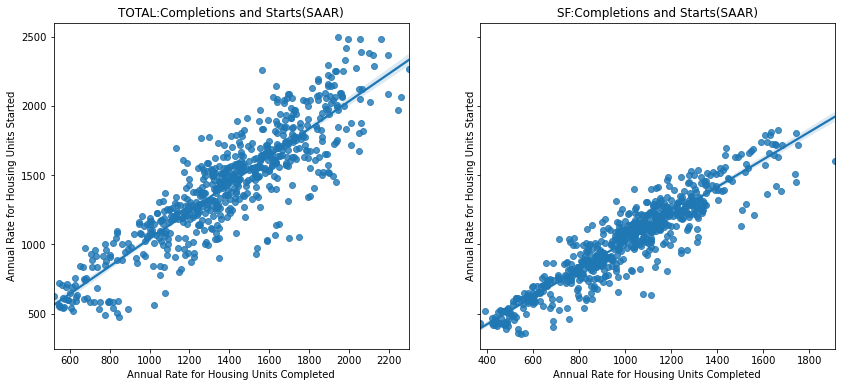

In [70]:
# Plot Completions and Starts
fig, axes = plt.subplots(1, 2, figsize=(14,6),sharey=True)
sns.regplot(ax=axes[0],x='Annual Rate for Housing Units Completed',y='Annual Rate for Housing Units Started',data=pvt_Adj_Total_Unit_National).set(title='TOTAL:Completions and Starts(SAAR)')
sns.regplot(ax=axes[1],x='Annual Rate for Housing Units Completed',y='Annual Rate for Housing Units Started',data=pvt_Adj_SF_Unit_National).set(title='SF:Completions and Starts(SAAR)')
plt.show()
##------Linear Relationship

In [108]:
# Pearson Coffelation Coefficient test Completion and Start
print(stats.pearsonr(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed'],pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']))
# Total Starts strongly positively correlated with Completion (coef=0.88 and possility of not correlated <<0.05)
print(stats.pearsonr(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Completed'],pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']))
# SF Starts strongly positively correlated with Completion (coef=0.92 and possility of not correlated <<0.05)

(0.8835285814720366, 1.0221891333985456e-207)
(0.9217440568071003, 5.157924878510262e-263)


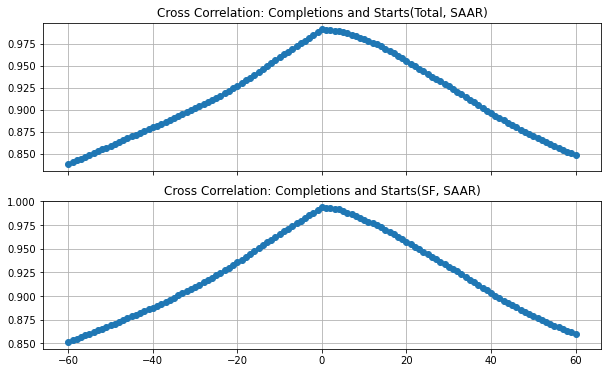

In [71]:
# Identify the most correlated time lag between completion and start
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,6),sharex=True)
# cross correlation using
# xcorr() function
ax1.xcorr(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed'], 
          pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=60, normed=True,
          lw=2)
ax2.xcorr(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Completed'], 
          pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=60, normed=True,
          lw=2)
# adding grid to the graph
ax1.grid(True)
ax2.grid(True)
#ax.axhline(0, color='blue', lw=2)

# adding title
ax1.title.set_text('Cross Correlation: Completions and Starts(Total, SAAR)')
ax2.title.set_text('Cross Correlation: Completions and Starts(SF, SAAR)') 

# show final plotted graph
plt.show()
## -----Same month has the strongest correlation

## 2.3 Feature enginnering

In [72]:
#Feature Engineer:Completion Ratio= Completion/Start
pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)']=pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed']/pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']
pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)']=pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Completed']/pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']

# 3- Time Series: Auto correlation/ Cross correlation

## 3.1 Starts- Autocorrelation

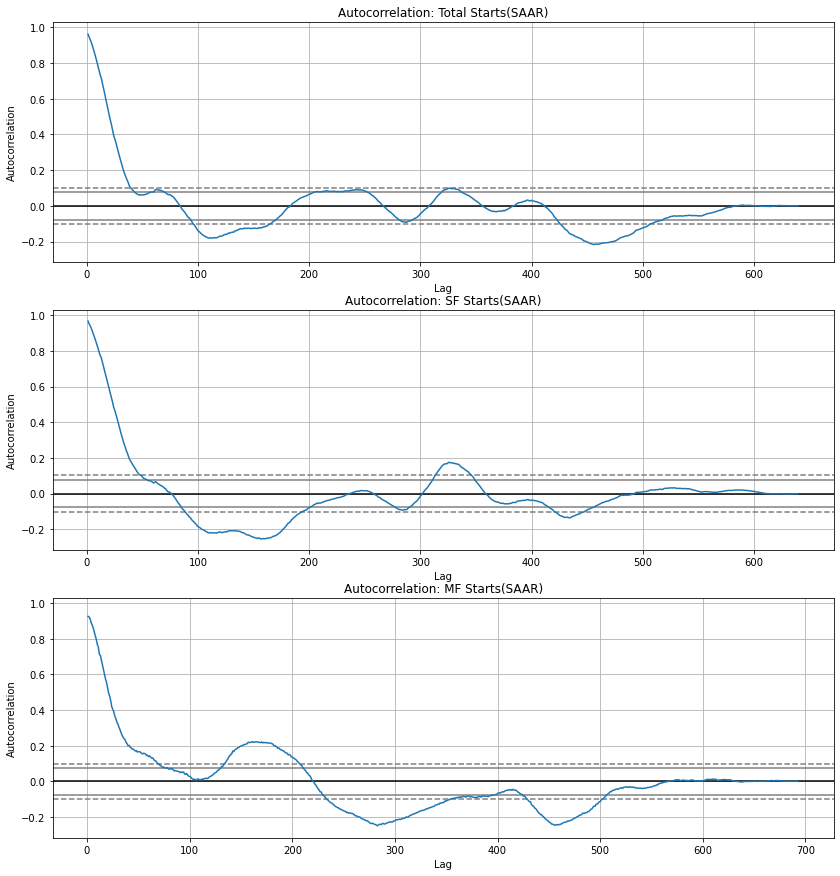

In [162]:
fig, axes = plt.subplots(3, 1, figsize=(14,15),sharey=True)
pd.plotting.autocorrelation_plot(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'],ax=axes[0]).set_title('Autocorrelation: Total Starts(SAAR)')
pd.plotting.autocorrelation_plot(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'],ax=axes[1]).set_title('Autocorrelation: SF Starts(SAAR)')
pd.plotting.autocorrelation_plot(pvt_Adj_MF_Unit_National['Annual Rate for Housing Units Started'],ax=axes[2]).set_title('Autocorrelation: MF Starts(SAAR)');

## 3.2 Permits versus Starts

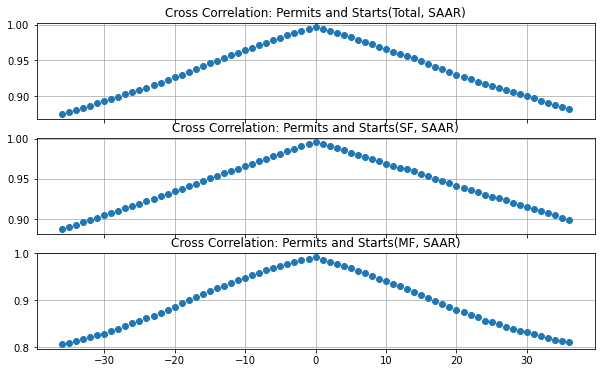

In [153]:
# Identify the most correlated time lag between Permit and start
fig, [ax1, ax2,ax3] = plt.subplots(3, 1, figsize=(10,6),sharex=True)
 
# cross correlation using
# xcorr() function
ax1.xcorr(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'], 
          pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=36, normed=True,
          lw=2)
ax2.xcorr(pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'], 
          pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=36, normed=True,
          lw=2)
ax3.xcorr(pvt_Adj_MF_Unit_National['Annual Rate for Housing Units Authorized in Permit-Issuing Places'], 
          pvt_Adj_MF_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=36, normed=True,
          lw=2)
# adding grid to the graph
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
#ax.axhline(0, color='blue', lw=2)

# adding title
ax1.title.set_text('Cross Correlation: Permits and Starts(Total, SAAR)')
ax2.title.set_text('Cross Correlation: Permits and Starts(SF, SAAR)') 
ax3.title.set_text('Cross Correlation: Permits and Starts(MF, SAAR)') 

# show final plotted graph
plt.show()
## -----Total/SF/MF Starts have strongest correlation with Permit in the same month

## 3.2 Completion Ratio versus Starts

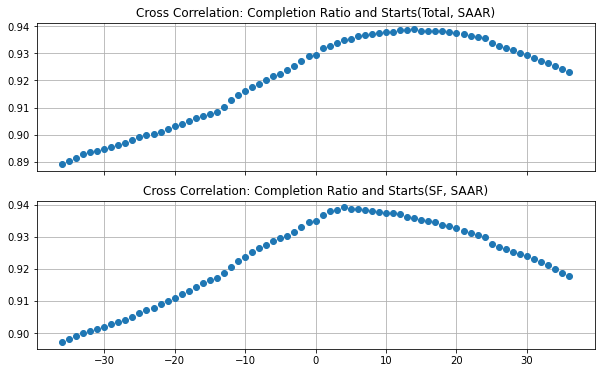

In [73]:
# Identify the most correlated time lag between completion ratio and start
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,6),sharex=True)
 
# cross correlation using
# xcorr() function
ax1.xcorr(pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)'], 
          pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=36, normed=True,
          lw=2)
ax2.xcorr(pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)'], 
          pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=False,
          maxlags=36, normed=True,
          lw=2)
# adding grid to the graph
ax1.grid(True)
ax2.grid(True)
#ax.axhline(0, color='blue', lw=2)

# adding title
ax1.title.set_text('Cross Correlation: Completion Ratio and Starts(Total, SAAR)')
ax2.title.set_text('Cross Correlation: Completion Ratio and Starts(SF, SAAR)') 

# show final plotted graph
plt.show()
## -----Total Starts have strongest correlation with completion ratio 14 months ago
## -----SF Starts have strongest correlation with completion ratio 4 months ago

In [74]:
#Feature Engineer:lagged Completion/Start
pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)_lag14']=pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)'].shift(periods=14)
##pvt_Adj_Total_Unit_National['Completion/Starts']=pvt_Adj_Total_Unit_National['Housing Units Completed']/pvt_Adj_Total_Unit_National['Housing Units Started']
pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)_lag4']=pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)'].shift(periods=4)
##pvt_Adj_SF_Unit_National['Completion/Starts']=pvt_Adj_SF_Unit_National['Housing Units Completed']/pvt_Adj_SF_Unit_National['Housing Units Started']

In [75]:
#Drop NA-lag
pvt_Adj_Total_Unit_National.dropna(axis=0,subset=['Completion/Starts(Annual Rate)_lag14'],inplace=True)
pvt_Adj_SF_Unit_National.dropna(axis=0,subset=['Completion/Starts(Annual Rate)_lag4'],inplace=True)

In [115]:
#Pearson Coffelation Coefficient test Completion Ratio and Start
print(stats.pearsonr(pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)'],pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']))
print(stats.pearsonr(pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)_lag14'],pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started']))
print(stats.pearsonr(pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)'],pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']))
print(stats.pearsonr(pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)_lag4'],pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started']))

(-0.4177380522264656, 7.851304288890708e-28)
(-0.41234390539599025, 4.299985010684356e-27)
(-0.3564438525984376, 1.7275924269340798e-20)
(-0.3492878982890806, 1.0969835583546936e-19)


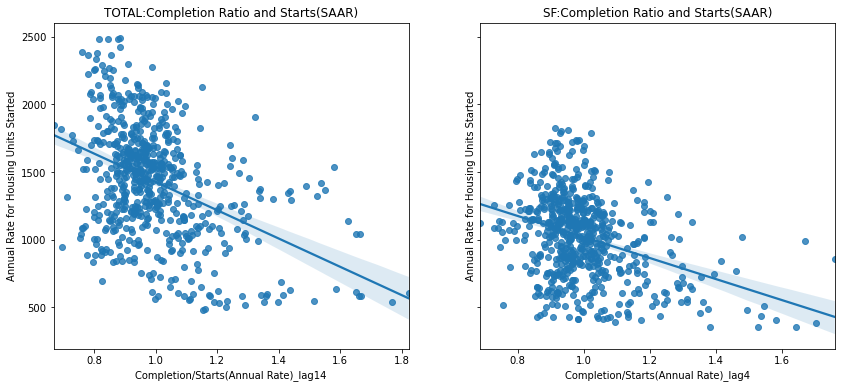

In [78]:
# Plot Completions Ratio and Starts
fig, axes = plt.subplots(1, 2, figsize=(14,6),sharey=True)
sns.regplot(ax=axes[0],x='Completion/Starts(Annual Rate)_lag14',y='Annual Rate for Housing Units Started',data=pvt_Adj_Total_Unit_National).set(title='TOTAL:Completion Ratio and Starts(SAAR)')
sns.regplot(ax=axes[1],x='Completion/Starts(Annual Rate)_lag4',y='Annual Rate for Housing Units Started',data=pvt_Adj_SF_Unit_National).set(title='SF:Completion Ratio and Starts(SAAR)')
plt.show()

In [79]:
# Look close to recent data
pvt_Adj_Total_Unit_National_Recent=pvt_Adj_Total_Unit_National.tail(36)
pvt_Adj_SF_Unit_National_Recent=pvt_Adj_SF_Unit_National.tail(36)

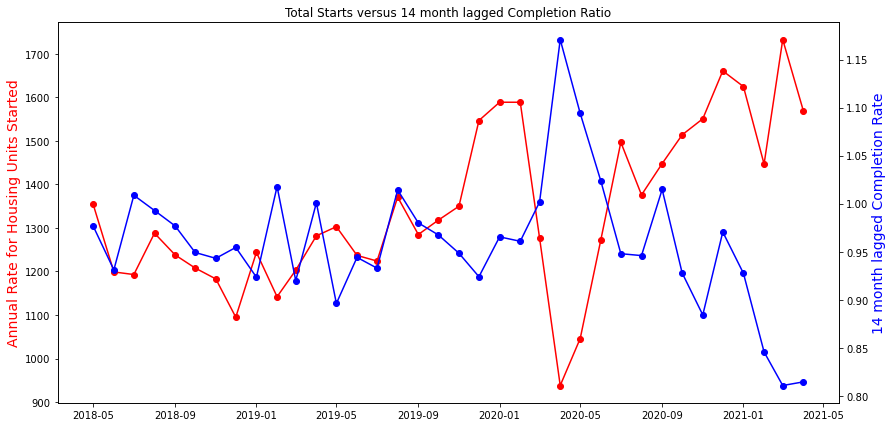

In [80]:
# plot Recent Tl Start and 14 month lagged Completion Rate
# create figure and axis objects with subplots()
f,ax=plt.subplots(figsize=(14,7))
# make a plot
ax.plot(pvt_Adj_Total_Unit_National_Recent.index, pvt_Adj_Total_Unit_National_Recent['Annual Rate for Housing Units Started'], label = "Start",color="red", marker="o")
# set y-axis label
ax.set_ylabel("Annual Rate for Housing Units Started",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pvt_Adj_Total_Unit_National_Recent.index, pvt_Adj_Total_Unit_National_Recent['Completion/Starts(Annual Rate)_lag14'], label = "Lagged Completion Ratio",color="blue",marker="o")
ax2.set_ylabel("14 month lagged Completion Rate",color="blue",fontsize=14)

ax2.title.set_text('Total Starts versus 14 month lagged Completion Ratio')
plt.show()
#------next month tl starts will go down

In [81]:
pvt_Adj_Total_Unit_National.head(5)

Category Description,Annual Rate for Housing Units Authorized in Permit-Issuing Places,Annual Rate for Housing Units Completed,Annual Rate for Housing Units Started,Housing Units Authorized But Not Started,Housing Units Under Construction,Completion/Starts(Annual Rate),Completion/Starts(Annual Rate)_lag14
Period,,,,,,,
1969-03-01,1438.0,1558.0,1561.0,NaN,NaN,0.998078,0.910870
1969-04-01,1441.0,1318.0,1524.0,NaN,NaN,0.864829,0.772368
1969-05-01,1328.0,1430.0,1583.0,NaN,NaN,0.903348,0.902456
1969-06-01,1349.0,1455.0,1528.0,NaN,NaN,0.952225,0.854569
1969-07-01,1278.0,1432.0,1368.0,NaN,NaN,1.046784,0.970881


In [48]:
pvt_Adj_Total_Unit_National.tail(20)

Category Description,Annual Rate for Housing Units Authorized in Permit-Issuing Places,Annual Rate for Housing Units Completed,Annual Rate for Housing Units Started,Housing Units Authorized But Not Started,Housing Units Under Construction,Completion/Starts(Annual Rate),Completion/Starts(Annual Rate)_lag14,Completion Ratio Group_14 month prior
Period,,,,,,,,
2019-09-01,1439.0,1136.0,1285.0,171.0,1160.0,0.884047,0.979883,80%-100%
2019-10-01,1509.0,1279.0,1318.0,188.0,1160.0,0.970410,0.967391,80%-100%
2019-11-01,1509.0,1252.0,1350.0,198.0,1166.0,0.927407,0.948304,80%-100%
2019-12-01,1453.0,1308.0,1547.0,182.0,1179.0,0.845507,0.923841,80%-100%
2020-01-01,1550.0,1288.0,1589.0,176.0,1196.0,0.810573,0.965342,80%-100%
2020-02-01,1478.0,1294.0,1589.0,166.0,1216.0,0.814349,0.960731,80%-100%
2020-03-01,1382.0,1267.0,1277.0,158.0,1215.0,0.992169,1.001608,100%-120%
2020-04-01,1094.0,1191.0,938.0,162.0,1194.0,1.269723,1.170753,100%-120%
2020-05-01,1246.0,1178.0,1046.0,170.0,1179.0,1.126195,1.093932,100%-120%


# PLEASE IGNORE EVERYTHING BELOW

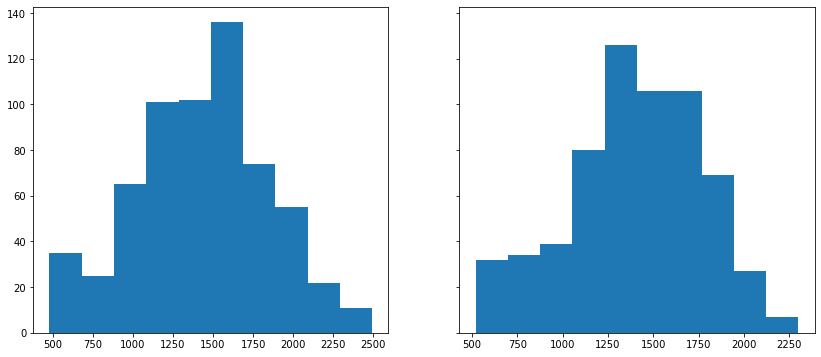

In [86]:
# Start Distribution
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,6),sharey=True)
ax1.hist(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'])
ax2.hist(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Completed'])
plt.show()

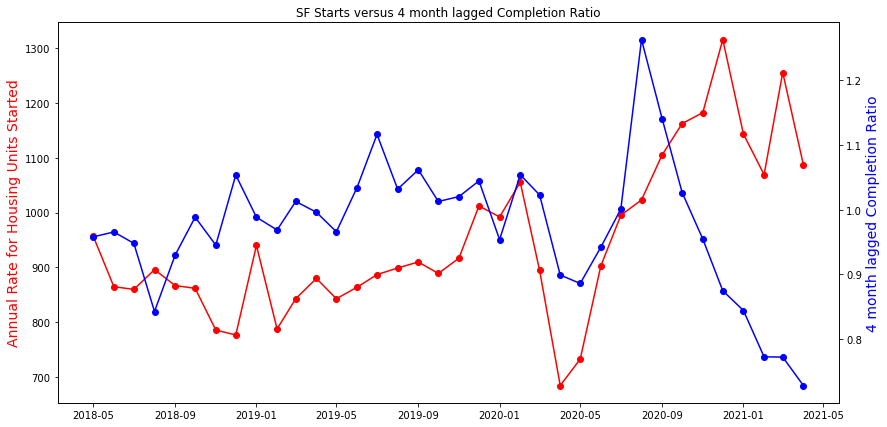

In [55]:
# plot Recent SF Start and 4 month lagged Completion Rate
# create figure and axis objects with subplots()
f,ax=plt.subplots(figsize=(14,7))
# make a plot
ax.plot(pvt_Adj_SF_Unit_National_Recent.index, pvt_Adj_SF_Unit_National_Recent['Annual Rate for Housing Units Started'], label = "Start",color="red", marker="o")
# set y-axis label
ax.set_ylabel("Annual Rate for Housing Units Started",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pvt_Adj_SF_Unit_National_Recent.index, pvt_Adj_SF_Unit_National_Recent['Completion/Starts(Annual Rate)_lag4'], label = "Lagged Completion Ratio",color="blue",marker="o")
ax2.set_ylabel("4 month lagged Completion Ratio",color="blue",fontsize=14)

ax2.title.set_text('SF Starts versus 4 month lagged Completion Ratio')
plt.show()
#------next month SF starts will go ??????

In [54]:
pvt_Adj_SF_Unit_National.tail(20)

Category Description,Annual Rate for Housing Units Authorized in Permit-Issuing Places,Annual Rate for Housing Units Completed,Annual Rate for Housing Units Started,Housing Units Authorized But Not Started,Housing Units Under Construction,Completion/Starts(Annual Rate),Completion/Starts(Annual Rate)_lag4
Period,,,,,,,
2019-09-01,894.0,868.0,910.0,84.0,525.0,0.953846,1.061684
2019-10-01,924.0,937.0,889.0,88.0,522.0,1.053993,1.012731
2019-11-01,940.0,938.0,917.0,94.0,519.0,1.022901,1.020293
2019-12-01,938.0,910.0,1012.0,89.0,521.0,0.899209,1.044494
2020-01-01,980.0,879.0,992.0,89.0,528.0,0.886089,0.953846
2020-02-01,1009.0,994.0,1055.0,89.0,534.0,0.942180,1.053993
2020-03-01,895.0,896.0,895.0,88.0,531.0,1.001117,1.022901
2020-04-01,673.0,865.0,685.0,89.0,515.0,1.262774,0.899209
2020-05-01,753.0,836.0,733.0,93.0,510.0,1.140518,0.886089


In [25]:
pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)_lag14'].describe()

count    626.000000
mean       0.994860
std        0.164706
min        0.668040
25%        0.893406
50%        0.963650
75%        1.049239
max        1.823214
Name: Completion/Starts(Annual Rate)_lag14, dtype: float64

In [27]:
#Create Completion Ratio Group
bins=[0.6,0.8,1,1.2,1.4,1.6,1.8,2]
bin_labels=['60%~80%','80%-100%','100%-120%','120%-140%','140%-160%','160%-180%','180%-200%']
pvt_Adj_Total_Unit_National['Completion Ratio Group_14 month prior']=pd.cut(pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)_lag14'],bins,right=False,labels=bin_labels)
pvt_Adj_Total_Unit_National.head()

Category Description,Annual Rate for Housing Units Authorized in Permit-Issuing Places,Annual Rate for Housing Units Completed,Annual Rate for Housing Units Started,Housing Units Authorized But Not Started,Housing Units Under Construction,Completion/Starts(Annual Rate),Completion/Starts(Annual Rate)_lag14,Completion Ratio Group_14 month prior
Period,,,,,,,,
1969-03-01,1438.0,1558.0,1561.0,NaN,NaN,0.998078,0.910870,80%-100%
1969-04-01,1441.0,1318.0,1524.0,NaN,NaN,0.864829,0.772368,60%~80%
1969-05-01,1328.0,1430.0,1583.0,NaN,NaN,0.903348,0.902456,80%-100%
1969-06-01,1349.0,1455.0,1528.0,NaN,NaN,0.952225,0.854569,80%-100%
1969-07-01,1278.0,1432.0,1368.0,NaN,NaN,1.046784,0.970881,80%-100%


In [29]:
Tl_14mon_Group=pvt_Adj_Total_Unit_National.groupby('Completion Ratio Group_14 month prior')['Annual Rate for Housing Units Started'].mean()
Tl_14mon_Group

Completion Ratio Group_14 month prior
60%~80%      1553.193548
80%-100%     1547.119114
100%-120%    1310.725146
120%-140%    1083.785714
140%-160%    1086.923077
160%-180%     792.000000
180%-200%     604.000000
Name: Annual Rate for Housing Units Started, dtype: float64

<AxesSubplot:xlabel='Completion Ratio Group_14 month prior', ylabel='Annual Rate for Housing Units Started'>

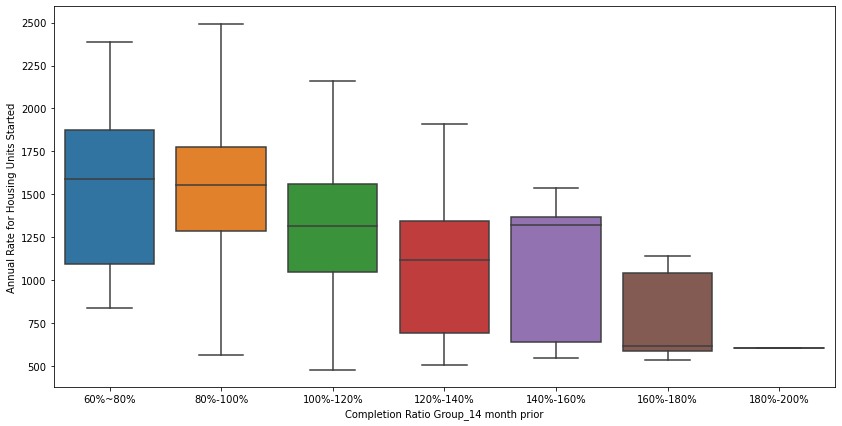

In [28]:
f,ax=plt.subplots(figsize=(14,7))
sns.boxplot(x ='Completion Ratio Group_14 month prior', y ='Annual Rate for Housing Units Started', data = pvt_Adj_Total_Unit_National)

In [ ]:
#TOTAL:lag14 month Correlation Coefficient
np.corrcoef(pvt_Adj_Total_Unit_National['Completion/Starts(Annual Rate)_lag14'],pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'])

In [ ]:
#SF:lag4 month Correlation Coefficient
np.corrcoef(pvt_Adj_SF_Unit_National['Completion/Starts(Annual Rate)_lag4'],pvt_Adj_SF_Unit_National['Annual Rate for Housing Units Started'])

In [ ]:
# Plot graph
fig = plt.figure(14)
ax1 = fig.add_subplot(211)
 
# cross correlation using
# xcorr() function
ax1.xcorr(pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'], 
          pvt_Adj_Total_Unit_National['Annual Rate for Housing Units Started'], 
          usevlines=True,
          maxlags=10, normed=True,
          lw=2)
# adding grid to the graph
ax1.grid(True)
ax1.axhline(0, color='blue', lw=2)
 
# show final plotted graph
plt.show()

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)


x, y = np.random.randn(2, 100)
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(x, usevlines=True, normed=True, maxlags=50, lw=2)
ax2.grid(True)

plt.show()

In [ ]:
pvt_Total_Unit_National['Gap=Completion-Start']=pvt_Total_Unit_National['Housing Units Completed']-pvt_Total_Unit_National['Housing Units Started']

In [ ]:
# plot Start and Completion lines
f,ax=plt.subplots(figsize=(14,7))
plt.plot(pvt_Total_Unit_National.index, pvt_Total_Unit_National['Housing Units Started'], label = "Start")
plt.plot(pvt_Total_Unit_National.index, pvt_Total_Unit_National['Housing Units Completed'], label = "Completion")
plt.legend()
plt.show()

In [ ]:
# Plot Gap and Start
sns.lmplot(x='Gap=Completion-Start',y='Housing Units Started',data=pvt_Total_Unit_National);

In [ ]:
# Corr Coef btw Start and Gap
pvt_Total_Unit_National.dropna(axis=0,subset=['Gap=Completion-Start'],inplace=True)
np.corrcoef(pvt_Total_Unit_National['Housing Units Started'],pvt_Total_Unit_National['Gap=Completion-Start'])

In [ ]:
pvt_Total_Unit_National_Gap=pvt_Total_Unit_National[pvt_Total_Unit_National['Gap=Completion-Start']<0]
pvt_Total_Unit_National_Catchup=pvt_Total_Unit_National[pvt_Total_Unit_National['Gap=Completion-Start']>=0]
my_color = np.where(pvt_Total_Unit_National['Gap=Completion-Start']>=0, "Green", "Red")
x = np.arange(1968, 2021, 1)
y= np.arange(1968, 2021, 1)/np.arange(1968, 2021, 1)-1

In [ ]:
# plot Start and Gap lines
f,ax=plt.subplots(figsize=(14,7))
plt.plot(pvt_Total_Unit_National.index, pvt_Total_Unit_National['Housing Units Started'], label = "Start")
plt.plot(pvt_Total_Unit_National.index, pvt_Total_Unit_National['Gap=Completion-Start'], label = "Gap/Catchup")
plt.legend()
plt.show()

In [ ]:
#Resample
pvt_Total_Unit_National_resample=pvt_Total_Unit_National.resample('3M',label='right').mean()
pvt_Total_Unit_National_resample_Gap=pvt_Total_Unit_National_resample[pvt_Total_Unit_National_resample['Gap=Completion-Start']<0]
pvt_Total_Unit_National_resample_Catchup=pvt_Total_Unit_National_resample[pvt_Total_Unit_National_resample['Gap=Completion-Start']>=0]


In [ ]:
# plot Start and Gap lines
f,ax=plt.subplots(figsize=(14,7))
plt.plot(pvt_Total_Unit_National_resample.index, pvt_Total_Unit_National_resample['Housing Units Started'], label = "Start")
plt.plot(pvt_Total_Unit_National_resample.index, pvt_Total_Unit_National_resample['Gap=Completion-Start'], label = "Gap/Catchup",color="Red")
plt.legend()
plt.show()

In [ ]:
pvt_Total_Unit_National['Gap=Completion-Start'].describe()

In [ ]:
#Create Gap Group
bins=[-80,-60,-40,-20,0,20,40,60,80,100]
bin_labels=['Gap:60~80','Gap:40~60','Gap:20~40','Gap:0~20','Catchup:0~20','Catchup:20~40','Catchup:40~60','Catchup:60~80','Catchup:80~100']
pvt_Total_Unit_National['Gap Group']=pd.cut(pvt_Total_Unit_National['Gap=Completion-Start'],bins,right=False,labels=bin_labels)

In [ ]:
f,ax=plt.subplots(figsize=(14,7))
sns.boxplot(x ='Gap Group', y ='Housing Units Started', data = pvt_Total_Unit_National)

In [ ]:
GapAnalysis=pvt_Total_Unit_National.groupby('Gap Group')['Housing Units Started','Housing Units Completed'].mean()
GapAnalysis

In [ ]:
pvt_Total_Unit_National_Index=pvt_Total_Unit_National.reset_index(level=0)
pvt_Total_Unit_National_Index.groupby('Gap Group')['Period'].agg(["count","max"])

In [ ]:
pvt_Total_Unit_National.groupby('Gap Group')[['Housing Units Started','Gap=Completion-Start']].corr()

In [ ]:
pvt_Total_Unit_National_Gap=pvt_Total_Unit_National[pvt_Total_Unit_National['Gap=Completion-Start']<0]
np.corrcoef(pvt_Total_Unit_National_Gap['Housing Units Started'],pvt_Total_Unit_National_Gap['Gap=Completion-Start'])